# West Nile Virus Predictions

This is my solution and analysis for the Wile Nile Virus Challenge from Kaggle. The challenge some significant feature engineering. The callenge description and data is available [here](https://www.kaggle.com/c/predict-west-nile-virus/overview).

We will answer the following quesitons in this notebook

1. What factors appear to be the drivers of mosquito population of West Nile Virus presence
2. How can my model with an understanding of driving factors be used to inform actions in Chicago
3. What evaluations metrics and strategies are appropriate

# Basic Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from scipy.stats import norm

import folium
import branca
import folium.plugins
import branca.colormap as cm

from pprint import pprint
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import RFECV

# Defining Functions

In [2]:
def unique_lat_lon(row):
    """
    Takes in a row from the mosquito dataframe and then replaces the lat and lon values
    for each trap number with the mean value for that trap number. This removes duplicate
    lat long entries for the same trap location
    """
    row['Latitude'] = mean_lat[row['Trap']]
    row['Longitude'] = mean_lon[row['Trap']]
    return row


def calculate_ratio_positives_pvalue(row):
    """
    takes in a row from the by_trap_df and calculates the test statistic (assuming the
     mean in normally distributed)
    """
    n = row['num_measurements']
    if n < 30:
        return np.nan
    mu_star = 0.052446
    mu = row['ratio_positives']
    sigma = row['std_positives']
    Tn = np.sqrt(n)*(mu-mu_star)/(sigma)
    if Tn < 1.28:
        return np.nan
    else:
        return 1-norm.cdf(Tn)


def persistence_backfill(df, feature):
    """
    Takes in a feature in the weather_data dataframe and then backfills any missing entries
    (marked by 'M' with the neaest previous non empty value).
    Returns: The backfilled pandas series
    """
    df[feature] = (df[feature].replace(to_replace='M', value=np.nan))
    df[feature] = (df[feature].fillna(method='backfill')).astype(np.float)
    return df[feature]


def significant_event_count(date, day_first, day_last, feature):
    """
    Takes in two days a date and calculates the count of the occurrances of feature
    between day_first and day_last days of the date and returns the count.
    feature should be a list of columns required
    """
    idx = weather_data.loc[weather_data['Date'] == date].index[0]
    idx_first = idx - day_first
    idx_last = idx - day_last
    val = np.sum(weather_data[feature].loc[idx_first:idx_last]).sum()
    return val


def temp_median(date, feature):
    """
    Accepts a date and a temperature based feature and returns the median temperature
    beginning the last 10 days preceeding the given date and returns this median.
    Feature should be a single string (column name from the weather_data df)
    """
    idx = weather_data.loc[weather_data['Date'] == date].index[0]
    idx_first = idx - 15
    idx_last = idx
    val = weather_data[feature].loc[idx_first:idx_last].median()
    return val


def total_rainfall(date):
    """
    Accepts a date and caluculates the total rainfall between 20 and 10 days preceeding
    the given date
    """
    idx = weather_data.loc[weather_data['Date'] == date].index[0]
    idx_first = idx - 15
    idx_last = idx
    val = weather_data['PrecipTotal'].loc[idx_first:idx_last].sum()
    return val


def absolute_humidity(date):
    """
    Calculates the absolute humidity in the last ten days preceeding the oberservation date
    """
    idx = weather_data.loc[weather_data['Date'] == date].index[0]
    idx_first = idx - 15
    idx_last = idx
    dry_bulb_temps = weather_data['Tavg'].loc[idx_first:idx_last]
    wet_bulb_temps = weather_data['WetBulb'].loc[idx_first:idx_last]
    pressure = weather_data['StnPressure'].loc[idx_first:idx_last]
    ew = .6108*np.exp((21.875*wet_bulb_temps)/(wet_bulb_temps + 265.5))
    e = ew - .000660*(1 + .00115*wet_bulb_temps)*(dry_bulb_temps - wet_bulb_temps)*pressure
    h = (2165 * e)/(dry_bulb_temps + 273.16)
    return h.median()


def pretty_barplot(labels, data, xlabel, ylabel, filename):
    """
    Creates prettier bar plots. Adapted from https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
    """

    # create some fake data
    labels = labels.values
    data = data.values
    to_plot = pd.Series(data, index=labels)
    df = pd.DataFrame({'percentage' : to_plot})
    df = df.sort_values(by='percentage')

    # we first need a numeric placeholder for the y axis
    my_range=list(range(1,len(df.index)+1))

    fig, ax = plt.subplots(figsize=(11,9))

    # create for each expense type an horizontal line that starts at x = 0 with the length 
    # represented by the specific expense percentage value.
    plt.hlines(y=my_range, xmin=0, xmax=df['percentage'], color='#007ACC', alpha=0.2, linewidth=15)

    # create for each expense type a dot at the level of the expense percentage value
    plt.plot(df['percentage'], my_range, "o", markersize=15, color='#007ACC', alpha=0.6)

    # set labels
    ax.set_xlabel(xlabel, fontsize=15, fontweight='black', color = '#333F4B')
    ax.set_ylabel('')

    # set axis
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.yticks(my_range, df.index)

    # # add an horizonal label for the y axis 
    fig.text(-0.23, 0.96, ylabel, fontsize=15, fontweight='black', color = '#333F4B')

    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)

    # set the spines position
    ax.spines['bottom'].set_position(('axes', -0.04))
    ax.spines['left'].set_position(('axes', 0.015))

    plt.savefig('./figures/' + filename +'.pdf', dpi=300, bbox_inches='tight')

# Reading in files

In [3]:
mosquito_data = pd.read_csv('./train.csv')

# EDA on the mosquito data

Before we build any models, I examine what the data is telling us. Are there detectable patterns that might be useful in future feature engineering?

In [4]:
mosquito_data.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


There are various species of mosquitos that around captured in these traps. The species might be a significant controbuting factor to the incidence of WVN. For this reason, I split the species into several dummy columns that encodes the species found in each trap. We revisit the influence of mosquito species in much more detail later in the notebook. 

In [5]:
species_columns = ['Erraticus', 'Pipiens', 'Restuans', 'Salinarius', 'Tarsalis', 'Territans']

r = mosquito_data.shape[0]
for species in species_columns:
    mosquito_data.insert(loc=3, column=species, value=np.zeros(r, dtype=np.int64))
    mosquito_data[species] = mosquito_data['Species'].apply(lambda entry: species.lower() in entry.lower())*1

In [6]:
mosquito_data = mosquito_data.drop(columns='Species')
mosquito_data.columns

Index(['Date', 'Address', 'Territans', 'Tarsalis', 'Salinarius', 'Restuans',
       'Pipiens', 'Erraticus', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

## Influence of trap location

The geographical locations of the traps is likely to be a significant driver for WNV presence i.e. it is likely that certain areas possess certain geographical features that it the presence of WNV more likely. So we first examine the data to study the influence of geography. We use the trap number as a proxy for the geography. I first group by Trap number. 

A prelimiary exploration of the dataset indicates that in some cases, for the same trap number, there were two different GPS location, so for this, we will use the mean value for the latitude and longitude and then update the dataframe. So in this case, we define a function `unique_lat_lon` that finds the mean latitude and longitude for each trap location and uses that as the entry.

In [7]:
grouped_by_trap = mosquito_data.groupby(by='Trap')
grouped_by_trap['Latitude'].unique()

Trap
T001                                 [41.953705]
T002                                  [41.95469]
T003                                 [41.964242]
T004                        [41.962728000000006]
T005                        [41.942114000000004]
T006                                 [41.990284]
T007                                 [41.994991]
T008                                 [42.008314]
T009    [41.981964000000005, 41.992478000000006]
T011                                 [41.944869]
T012                                 [41.991429]
T013                                 [41.923738]
T014                                 [41.970248]
T015                                 [41.974089]
T016                                 [42.011601]
T017                        [41.960615999999995]
T018                                 [42.010412]
T019                                  [41.94983]
T025                                 [41.979243]
T027                        [41.984809000000006]
T028           

Next, I calculate a series of metrics grouped by trap so that we can understand which areas need most resources from the city of Chicago, are there any locations that are at pariticularly high risk, etc. 

#### Number of times a particular trap was sampled

Next, we want to see how often the different traps around the city were sampled. This information would help us see put in perspective any positive results for WNV sightings. Of course, traps that are sampled more frequently are more likely to have positive sightings. Moreover, knowing this information might also give us leads into which locations need sampling more often.

#### Number of total WNV positives by trap

Here we calculate which traps have seen the most cases of WNV

#### Normalized number of WNV positives by trap

Some traps are sampled more often than others, so to really understand the frequency of sightings, I really need to normalize the absolute number of sightings with the number of of times a certain trap was sampled. I then fold everything into a dataframe. 

In [8]:
mean_lat = grouped_by_trap['Latitude'].unique().apply(np.mean)
mean_lon = grouped_by_trap['Longitude'].unique().apply(np.mean)

number_measurements_by_trap = grouped_by_trap['Date'].count()
number_positives_by_trap = grouped_by_trap['WnvPresent'].sum()
std_positives_by_trap = grouped_by_trap['WnvPresent'].std()
num_mosquitos_by_trap_avg = grouped_by_trap['NumMosquitos'].mean()

by_trap_df = pd.DataFrame(columns=['Trap', 'num_measurements'])

by_trap_df['Trap'] = number_measurements_by_trap.index
by_trap_df['num_measurements'] = number_measurements_by_trap.values
by_trap_df['Latitude'] = mean_lat.values
by_trap_df['Longitude'] = mean_lon.values
by_trap_df['num_positives'] = number_positives_by_trap.values
by_trap_df['ratio_positives'] = by_trap_df['num_positives']/by_trap_df['num_measurements']

by_trap_df['std_positives'] = std_positives_by_trap.values
by_trap_df['num_mosquitos_avg'] = num_mosquitos_by_trap_avg.values

by_trap_df.sort_values(by='ratio_positives', ascending=False).head()

,Trap,num_measurements,Latitude,Longitude,num_positives,ratio_positives,std_positives,num_mosquitos_avg
89,T143,31,41.999129,-87.795585,6,0.193548,0.401610,7.419355
5,T006,24,41.990284,-87.797127,4,0.166667,0.380693,4.458333
4,T005,14,41.942114,-87.776385,2,0.142857,0.363137,3.571429
129,T233,50,42.009876,-87.807277,7,0.140000,0.350510,15.160000
12,T014,30,41.970248,-87.787992,4,0.133333,0.345746,12.133333


Note: Instead of normalizing by the number of measurements, if we instead normalized by the total number of mosquitos captured at a particular trap locations, the numbers inthe above table change and the ordering changes slightly too. I chose to use the num_measurements column as the normalizing factor because the WnvPresent column is binary; it doesn't scale with the number of mosquitos in the trap. So the num_measurements seemes to be a more reasonable metric because for each measurement (i.e. a binary random variable coding whether not a measurement occured at a given trap) there is a binary record of WnvPresent.  

(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 8 Text yticklabel objects>)

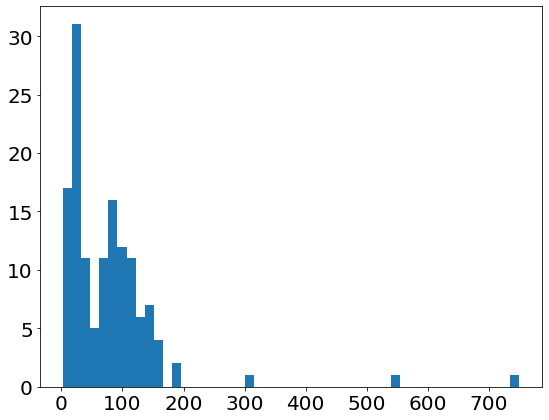

In [15]:
figh, axh = plt.subplots(nrows=1, ncols=1, figsize=(9,7))
ax = by_trap_df['num_measurements'].hist(grid=False, bins=50)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

### Plotting folium maps of number of measurements, num positives and ratio positives by location

The size in the map below corresponds to the number of measurents made and the color corresponds to the number of positive tests of WNV presence. We see a strong correlation between the number of measurements made and the number of positives, so we should really look at a normalized metric to dig into which locations are more problematic than others. In fact, there is a correlation co-efficient of 0.92. 

### Plotting density of mosquitos per trap

Density is defined as the average number of mosquitos caught in each trap

In [9]:
# Plotting number_mosquitos_per_trap_average
map_where_traps= folium.Map(location=[by_trap_df['Latitude'].mean()-.07,
                              by_trap_df['Longitude'].mean()],
                              zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(map_where_traps)
ma = by_trap_df['num_mosquitos_avg'].max()
by_trap_df.apply(lambda row: 
                    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                                        radius=6,
                                        fill=True,
                                        stroke=False,
                                        # color=colormap(row['ratio_positives']),
                                        color='blue',
                                        fill_opacity=.8).add_to(map_where_traps),
                 axis=1)
map_where_traps

In [10]:
# Plotting number_mosquitos_per_trap_average
map_num_mosquitos_avg= folium.Map(location=[by_trap_df['Latitude'].mean()-.07,
                              by_trap_df['Longitude'].mean()],
                              zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(map_num_mosquitos_avg)
ma = by_trap_df['num_mosquitos_avg'].max()
by_trap_df.apply(lambda row: 
                    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                                        radius=row['num_mosquitos_avg']/ma*20,
                                        fill=True,
                                        stroke=False,
                                        # color=colormap(row['ratio_positives']),
                                        color='blue',
                                        fill_opacity=.8).add_to(map_num_mosquitos_avg),
                 axis=1)
map_num_mosquitos_avg

### Number of Measurements and Number of Positives Map 

In [11]:
# num_measurements and num_positives

color_min = by_trap_df['num_positives'].min()
color_max = by_trap_df['num_positives'].max()
colormap = cm.LinearColormap(colors=['blue','red'],
                             index=[0, 23],
                             vmin=color_min,
                             vmax=color_max)
# colormap = cm.linear.OrRd
map_num_measurements = folium.Map(location=[by_trap_df['Latitude'].mean()-.07,
                              by_trap_df['Longitude'].mean()],
                              zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(map_num_measurements)
mn = by_trap_df['num_measurements'].max()
by_trap_df.apply(lambda row: 
                    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                                        radius=row['num_measurements']/mn*40,
                                        fill=True,
                                        stroke=False,
                                        color=colormap(row['num_positives']),
                                        # color='green',
                                        fill_opacity=1).add_to(map_num_measurements),
                 axis=1)
map_num_measurements

### Map of ratio of positives

In [12]:
# Plotting ratio_positives

color_min = by_trap_df['ratio_positives'].min()
color_max = by_trap_df['ratio_positives'].max()
colormap = cm.LinearColormap(colors=['blue','red'],
                             index=[0, .8],
                             vmin=color_min,
                             vmax=color_max)

map_ratio_positives = folium.Map(location=[by_trap_df['Latitude'].mean()-.07,
                              by_trap_df['Longitude'].mean()],
                              zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(map_ratio_positives)
mr = by_trap_df['ratio_positives'].max()
by_trap_df.apply(lambda row: 
                    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                                        radius=6,
                                        fill=True,
                                        stroke=False,
                                        color=colormap(row['ratio_positives']/mr),
                                        fill_opacity=0.75).add_to(map_ratio_positives),
                 axis=1)
map_ratio_positives

### Barplot of the ratio of number of positives to number of sightings

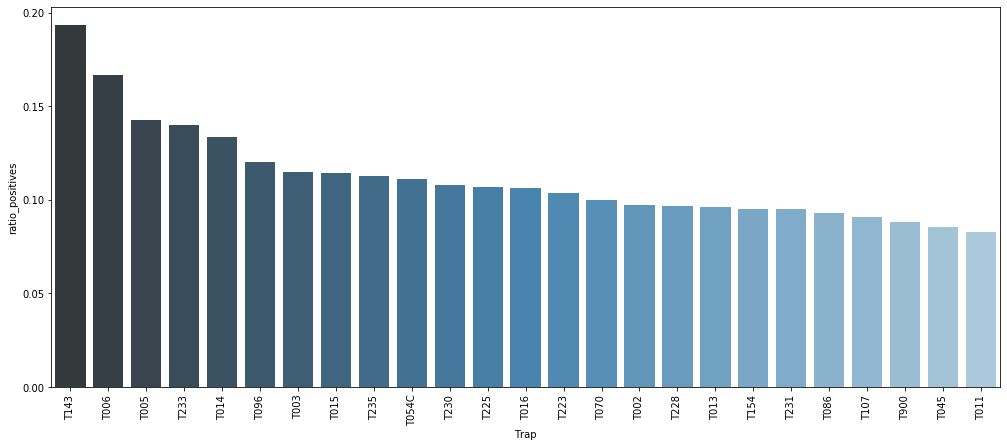

In [13]:
# Barplot of highest ratio of mosquito sightings
fig_ratio_positives, ax_ratio_positives = plt.subplots(nrows=1, ncols=1, figsize=(17,7))
ax_ratio_positives.set_xticklabels(labels=by_trap_df['Trap'], rotation=90)
ax_ratio_positives = sns.barplot(x='Trap', y='ratio_positives', data=by_trap_df.sort_values(by=['ratio_positives'], ascending=False)[:25], palette='Blues_d')
sns.set_context('talk', font_scale=1.4)

### Calcuaton of statistical significance of the ratio positives.

While I find several traps that have incidence ratios higher than the mean incidence ratio, each trap has a different number of measurements and standard deviances. To actually verify if the higher means at certain traps are statistically significant, I perform statistical significance tests. I assume independence between each measurement of positive incidence and use the sample mean $\bar{X}_n$ as the estimator. The null hypothesis is that the mean at a particular trap is the same as the mean for all traps across all measurements. So I am testing between the hypotheses: $\mu \leq \mu^*$ and $\mu > \mu^*$. The function that does the calculation of the p-value if defined in `calculate_ratio+_positives_pvalue`


In [14]:
by_trap_df['pvalue_ratio_positives'] = by_trap_df.apply(lambda row: calculate_ratio_positives_pvalue(row), axis=1)
by_trap_df.sort_values(by='ratio_positives', ascending=False)

,Trap,num_measurements,Latitude,Longitude,num_positives,ratio_positives,std_positives,num_mosquitos_avg,pvalue_ratio_positives
89,T143,31,41.999129,-87.795585,6,0.193548,0.401610,7.419355,0.025221
5,T006,24,41.990284,-87.797127,4,0.166667,0.380693,4.458333,NaN
4,T005,14,41.942114,-87.776385,2,0.142857,0.363137,3.571429,NaN
129,T233,50,42.009876,-87.807277,7,0.140000,0.350510,15.160000,0.038674
12,T014,30,41.970248,-87.787992,4,0.133333,0.345746,12.133333,0.100027
74,T096,50,41.731922,-87.677512,6,0.120000,0.328261,11.560000,0.072810
2,T003,122,41.964242,-87.757639,14,0.114754,0.320039,11.032787,0.015761
13,T015,35,41.974089,-87.824812,4,0.114286,0.322803,4.828571,NaN
130,T235,62,41.776428,-87.627096,7,0.112903,0.319058,8.983871,0.067847
40,T054C,9,41.925652,-87.633590,1,0.111111,0.333333,16.111111,NaN


### Plot locations and ratios for traps whose means exceed the overall mean in a statistically significant way

In [15]:
# Size of the circle is the mean for the location
# Opacity of the cirlce is confidence (higher opacity is lower p-value)
by_trap_df_nonan = by_trap_df.dropna(axis=0)
minp = by_trap_df_nonan['pvalue_ratio_positives'].min()
maxp = by_trap_df_nonan['pvalue_ratio_positives'].max()
color_min = by_trap_df_nonan['ratio_positives'].min()
color_max = by_trap_df_nonan['ratio_positives'].max()
colormap = cm.LinearColormap(colors=['blue','red'],
                             index=[0, .2],
                             vmin=0,
                             vmax=1)

map_sig_ratio_positive = folium.Map(location=[by_trap_df['Latitude'].mean()-.07,
                              by_trap_df['Longitude'].mean()],
                              zoom_start=10)
folium.TileLayer('cartodbpositron').add_to(map_sig_ratio_positive)

by_trap_df_nonan.apply(lambda row: 
                    folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                                        radius=row['ratio_positives']*100,
                                        fill=True,
                                        stroke=False,
                                        color='red',
                                        popup=row['Trap'],
                                        fill_opacity=(1 - (row['pvalue_ratio_positives'] - minp)/(maxp-minp))).add_to(map_sig_ratio_positive),
                 axis=1)
map_sig_ratio_positive


The points above are at high risk - their means are above the overall incidence of WNV in Chiacago by a statistically significant amount (and some of the incidence rates are three times the city average). The recommendation for health authorities is to do more frequent testing at these locations and focus more resources on mosquito populaiton control here. Interestingly, the areas with the highest density of mosquitos show rather low rates of WNV

## Effect of Mosquito Species 

We have already looked at the influence of location and how that informs the presence of WNV. Another factor to explore is the mosquito species. Are some species more correlated with the presence of WNV than others? This might inform authorities to specially track or understand the distribution and behavioral patterns of that species for more effective control of WNV.

To do this, we take the naive approach at this stage and just look at a correlation matrix between the mosquito species and whether WNV was present or not.

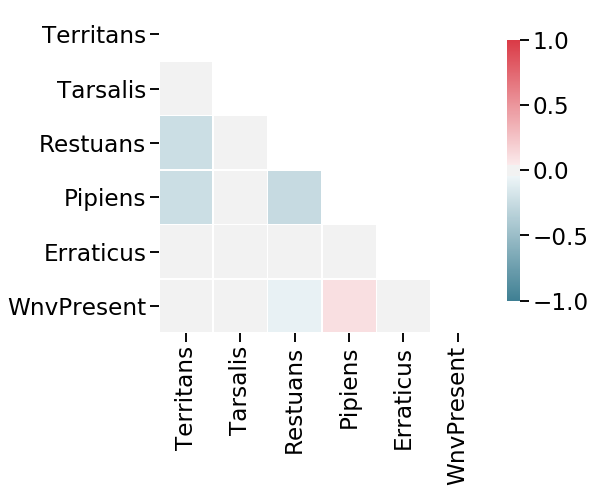

In [16]:
corr = (mosquito_data[['Territans', 'Tarsalis', 'Restuans', 'Pipiens', 'Erraticus', 'WnvPresent']]).corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

We next group by mosquito to see how many sightings of different mosquito species were measured, and then find the normalized incidence of WNV i.e. for each mosquito column, we find the total sightings. It turns out that the total measurements in each case was about the same (7400) so we don't do any further normalization.

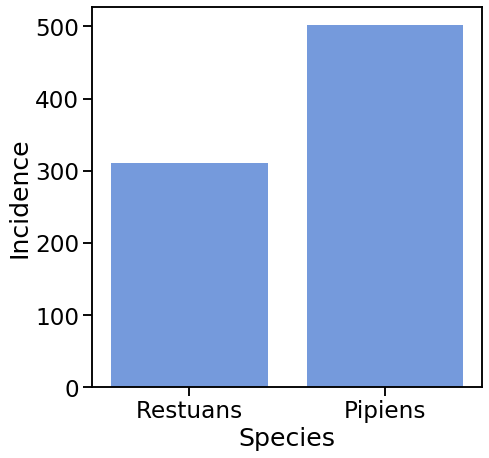

In [17]:
species = mosquito_data.columns[2:8]

mos_df = pd.DataFrame(columns=['Species', 'Incidence'])
for i, mos in enumerate(species):
    num_sightings = mosquito_data[mos].sum()
    num_incidence = (mosquito_data[mosquito_data[mos] == 1]['WnvPresent']).sum()
    if num_incidence != 0:
        mos_df = mos_df.append({'Species': mos, 'Incidence': num_incidence},
                               ignore_index=True)
fig_mos, ax_mos = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax_mos = sns.barplot(x='Species', y='Incidence', data=mos_df, color='cornflowerblue')

Pipens almost single handedly drives the rate of WNV incidence. Restuans often co-occurs with Pipiens, but is not a driver (there are very few Restuans only positive incidence data)

# Baseline Model

For a baseline model, we are just going to use the mosquito information and see how well we are able to predict the incidence of WNV. For this, we only have access to species information and location information. I will be dropping the address information because that information is encoded in the GPS location.

## Feature Engineering

One level of feature engineering we will do here is to make sure we capture the month becuase this might be important (and WNV might be more active in certain times of the year). So we will also track the month, and use dummy variable encoding. Inspection of the data shows that the months for which we have mosquito data are from May through October.

The first thing we do is to just plot histograms to see if there are more cases of WNV in certain months. We will create a month column and then group by month and look at some statistics. We will also have to look at the number of inspections each month because the number of mosquitos caught as well as the number of cases of WNV will depend on how frequently the inspections and sampling was done. 

In [18]:
# First drop unnecessary columns
mosquito_data_lr = mosquito_data.drop(columns=['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'])

In [19]:
# Adding in the month as dummy columns
mosquito_data_lr.insert(loc=1, column='Month', value=np.zeros(mosquito_data.shape[0], dtype=np.int64))
mosquito_data_lr['Month'] = (mosquito_data_lr['Date'].apply(lambda date:date.split('-')[1])).astype(np.int64)
mosquito_data_lr[mosquito_data_lr['WnvPresent'] == 1]

,Date,Month,Territans,Tarsalis,Salinarius,Restuans,Pipiens,Erraticus,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
553,2007-07-18,7,0,0,0,1,1,0,T215,41.686398,-87.531635,50,1
603,2007-07-25,7,0,0,0,1,1,0,T115,41.673408,-87.599862,50,1
611,2007-07-25,7,0,0,0,1,1,0,T115,41.673408,-87.599862,50,1
618,2007-07-25,7,0,0,0,0,1,0,T115,41.673408,-87.599862,50,1
660,2007-07-25,7,0,0,0,0,1,0,T115,41.673408,-87.599862,50,1
661,2007-07-25,7,0,0,0,0,1,0,T115,41.673408,-87.599862,50,1
777,2007-08-01,8,0,0,0,1,1,0,T002,41.954690,-87.800991,50,1
778,2007-08-01,8,0,0,0,1,1,0,T002,41.954690,-87.800991,21,1
784,2007-08-01,8,0,0,0,1,1,0,T015,41.974089,-87.824812,5,1
812,2007-08-01,8,0,0,0,1,1,0,T086,41.688324,-87.676709,33,1


In [20]:
mosquito_data_lr.shape[0]

10506

In [21]:
# Group by month and then look at some statistics
# Incidence is normalized by the total number of mosquitos measured in a month
grouped_by_month = mosquito_data_lr.groupby('Month')
grouped_by_month['Month'].count()
by_month_df = pd.DataFrame(columns=['Month', 'num_measurements', 'total_mosquitos', 'total_incidence'])

by_month_df['Month'] = grouped_by_month['Month'].count().index
by_month_df['num_measurements'] = grouped_by_month['Month'].count().values
by_month_df['total_mosquitos'] = grouped_by_month['NumMosquitos'].sum().values
by_month_df['total_incidence'] = grouped_by_month['WnvPresent'].sum().values

by_month_df['incidence_ratio'] = by_month_df['total_incidence']/by_month_df['total_mosquitos']*100

by_month_df


,Month,num_measurements,total_mosquitos,total_incidence,incidence_ratio
0,5,84,230,0,0.000000
1,6,1571,16578,1,0.006032
2,7,2606,37248,46,0.123497
3,8,3751,58036,377,0.649597
4,9,2218,21029,125,0.594417
5,10,276,1918,2,0.104275


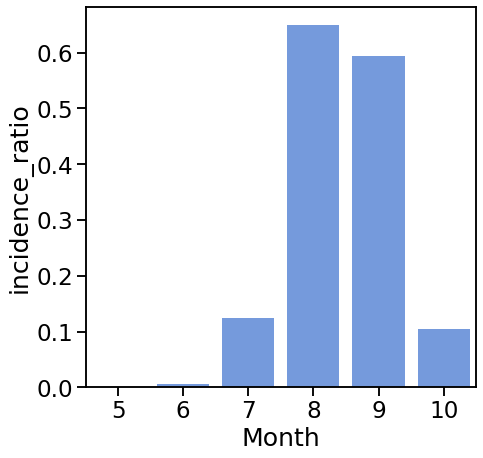

In [22]:
# Plot normalized incidence
sns.set_context("talk", font_scale=1.4)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
ax = sns.barplot(x='Month', y='incidence_ratio', data=by_month_df, color='cornflowerblue')

Because there is a strong dependence between month and incidence, we will, like before, generate dummy variables for each month as features in our model

In [23]:
months = ['May', 'June', 'July', 'August', 'September', 'October']
loc = 2
base_month = 5
z = np.zeros(mosquito_data_lr.shape[0], dtype=np.int64)
for month in months:
    mosquito_data_lr.insert(loc=loc, column=month, value=z)
    mosquito_data_lr[month] = (mosquito_data_lr['Month'] == base_month)*1
    loc += 1
    base_month += 1

In [24]:
mosquito_data_lr = mosquito_data_lr.drop(columns=['Trap', 'Month'])

In [25]:
mosquito_data_lr.columns

Index(['Date', 'May', 'June', 'July', 'August', 'September', 'October',
       'Territans', 'Tarsalis', 'Salinarius', 'Restuans', 'Pipiens',
       'Erraticus', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent'],
      dtype='object')

## Logistic Regression Model

We are now ready to run a baseline model. We will use Logistic Regression as a first pass, and examine some of the properties of the model and compare against some metrics

In [26]:
cols = mosquito_data_lr.columns
X = mosquito_data_lr[cols[1:-1]]  # Dont use date because already encoded month
y = mosquito_data_lr[cols[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

scaler_train = StandardScaler()
X_train = scaler_train.fit_transform(X=X_train, y=y_train)

scaler_test = StandardScaler()
X_test = scaler_test.fit_transform(X=X_test, y=y_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(f'The test accuracy is {accuracy_score(y_predict, y_test)}')

The test accuracy is 0.950523311132255


### Plot the ROC curve

ROC AUC=0.8383980733004269
The F1 score for the model is 0.07142857142857144


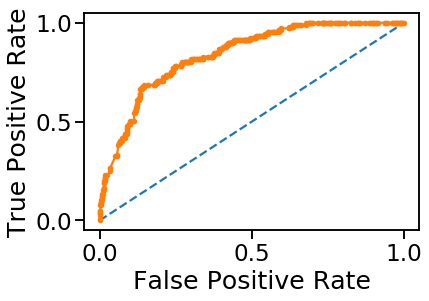

In [27]:
# Plotting the ROC curve
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
print(f'ROC AUC={lr_auc}')
print(f'The F1 score for the model is {f1_score(y_predict, y_test)}')

Already, just with the month and location data, we are able to predict the incidence of WNV with high accuracy (96%) and with reasonably good ROC AUC (0.84). But the F1 score is really poor! My model is pretty much marking everything 0 probably because it is so imbalanced. 

So I take the approach of subsampling: given that I have several 1, subsample the same number of 0 datapoints to have a more balanced dataset.

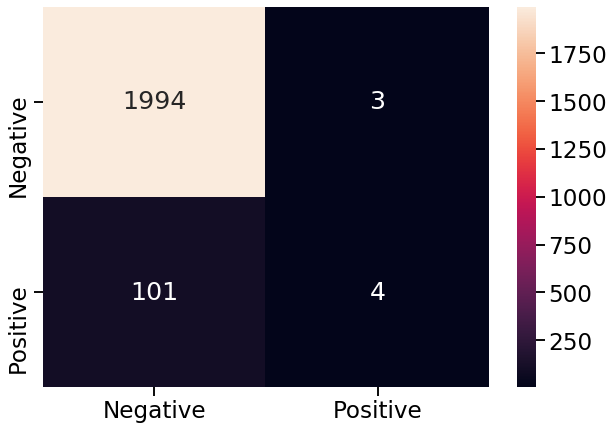

In [28]:
cm = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index = ['Negative', 'Positive'],
                  columns = ['Negative', 'Positive'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In the above confusion matrix: rows are the actual data and columns are the predicted data. We see that my classifier does poorly because of the really large False negative rate. I could play with the threshold, but what ismuch much better is subsampling.

## Subsampling the dataset to get more balanced data. 

My classifier does poorly because of the heavily imbalanced dataset. Given that the total number of positives in the dataset is 551, I will arbitrarily subsmaple the same number of negatives to create a more balanced dataset. I will then split this dataset into train and test splits and perform the logistic regression.  

In [28]:
mosquito_data_lr_pos = mosquito_data_lr[mosquito_data_lr['WnvPresent'] == 1]
n = mosquito_data_lr_pos.shape[0]  # Number of positive samples = 551
mosquito_data_lr_neg = mosquito_data_lr[mosquito_data_lr['WnvPresent'] == 0]
mosquito_data_lr_neg_sampled = mosquito_data_lr_neg.sample(n=n, random_state=50) 

mosquito_data_lr_sampled = pd.concat([mosquito_data_lr_pos, mosquito_data_lr_neg_sampled])
mosquito_data_lr_sampled = shuffle(mosquito_data_lr_sampled, random_state=42)

### Performing the logistic regression on the subsampled dataset

In [29]:
cols = mosquito_data_lr_sampled.columns
X = mosquito_data_lr_sampled[cols[1:-1]]
y = mosquito_data_lr_sampled[cols[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

scaler_train = StandardScaler()
X_train = scaler_train.fit_transform(X=X_train, y=y_train)

scaler_test = StandardScaler()
X_test = scaler_test.fit_transform(X=X_test, y=y_test)

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(f'The test accuracy is {accuracy_score(y_predict, y_test)}')

The test accuracy is 0.7647058823529411


### Plot the ROC and find Accuracy, F1 Score

ROC AUC=0.8366125594359731
The F1 score for the model is 0.7657657657657657


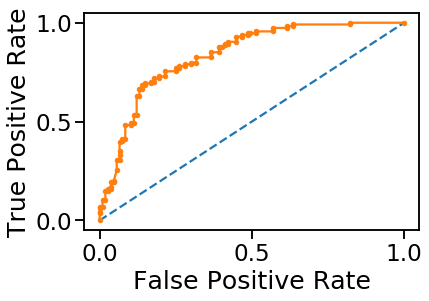

In [30]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
print(f'ROC AUC={lr_auc}')
print(f'The F1 score for the model is {f1_score(y_predict, y_test)}')

Voila! Significantly better model. although my accuracy is lower (0.76), the ROC AUC is even higher (0.86) and my F1 score has increased by an order of magnitude (0.76)! 

### Which features are driving WNV (using just the Mosquito Data)

To find the most important features, we are going to just look at the coefficients of the fit logistic regression parameters. Coefficients with large magnitudes are important. Positive coefficients drive up the incidence rate, while negative coefficients drive down the incidence rate.

At this point, because this is the baseline model, we take this crude approach, but we later relax this assumption and look at recursive feature elimination as a way to find feature importances more rigorously.

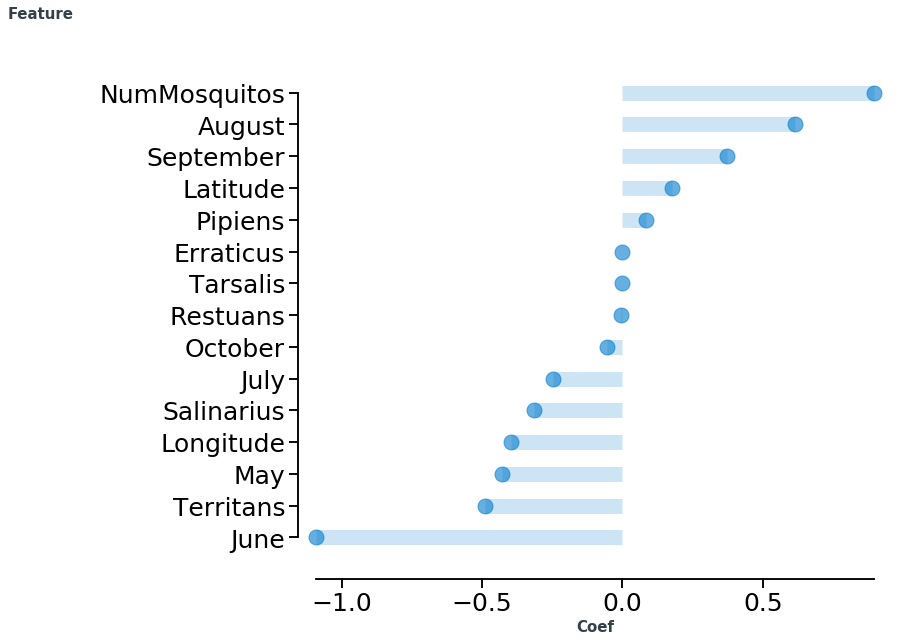

In [31]:
lr_coefs = clf.coef_[0]
feature_cols = cols[1:-1]
lr_coef_df = pd.DataFrame(columns=['Feature', 'Coef'])
lr_coef_df['Feature'], lr_coef_df['Coef'] = feature_cols, lr_coefs
lr_coef_df = lr_coef_df.sort_values(by='Coef', ascending=False)

# fig_lr_coef, ax_lr_coef = plt.subplots(nrows=1, ncols=1, figsize=(19,7))
# ax_lr_coef.set_xticklabels(labels=lr_coef_df['Feature'], rotation=90)
# ax_lr_coef = sns.barplot(x='Feature', y='Coef', color='cornflowerblue', data=lr_coef_df)

pretty_barplot(lr_coef_df['Feature'], lr_coef_df['Coef'], 'Coef', 'Feature', 'baseline_model_feature_importance')

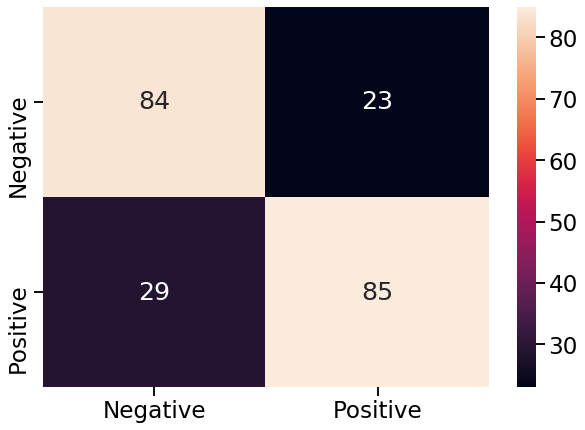

In [32]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index = ['Negative', 'Positive'],
                  columns = ['Negative', 'Positive'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

The metrics for the final baseline model that uses just the information from month, location of trap and species of mosquito are:

* Accuracy: 0.76
* ROC AUC: 0.84
* F1-Score: 0.76

Can we do better? We explore this question by folding in the weather data and then checking against our baseline model.

# Folding in the weather data

First, let us inspect the weather data and examine the datatypes

In [33]:
weather_data = pd.read_csv('./weather.csv')
print(weather_data.dtypes)
weather_data

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,...,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,...,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,...,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,...,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,...,,M,M,M,T,29.46,30.09,11.2,7,11.5


A visual exploration of the datasets suggests a few data preliminary cleaning and processing steps:

1. The `CodeSum` column is a collection of significant weather events such as tornados or thundershowers. We will be arranging this column alphabetically and then creating dummy columns for each dummy category. 

2. There are a large number of correlated variables. For example the date and the sunrise and sunset variables. It might be worth looking at correlation plots and then also finding variation inflation factors to see how much correlation there is between variables and make decisions on which ones to drop. We will be dropping the sunrise and sunset columns.

3. This is data only for summer months, so it seems that any data involving snowfall or ice can be dropped. Comparing the weather data to the NOAA explanation of the columns, this seems to suggest that `Depth`, `Water1` and `Snowfall` can be dropped.

4. It seems like the data from Station 1 and Station 2 are highly correlated, but station 2 has more holes and more missing data. So if upon further examination the correlation holds, we will drop Station 2 data. 

5. Ultimately, we will do some feature engineering on the weather data so that we can augment our mosquito dataset 

## Cleaning the weather dataset

We now drop a few columns by making a few assumptions. First, we drop snowfall parameters such as `Depth`, `Water1` and `SnowFall` because they are irrelvant for the data consisting only of summer months when mosquitos are active. We also drop degree days columns `Heat` and `Cool` because these are linearly correlated with `Tavg` because they are measured as an offset from `Tavg`.

In [34]:
# First drop the snow related columns because they are not of relevance for summer months
weather_data = weather_data.drop(columns=['Depth', 'Water1', 'SnowFall', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'SeaLevel'])

## Justification for why I drop data from Station 2 (Plots need cleaning up)

I see that for each date, there are weather recordings from two different stations. It is likely that if the data from the two stations are accurate, then these data are also likely to be strongly correlated. We check this assumption by first splitting the dataframe into two (one for each station) and then check the correlation between corresponding columns in the two tables.

In [35]:
weather_data_station1 = weather_data[weather_data['Station'] == 1]
weather_data_station2 = weather_data[weather_data['Station'] == 2]

Next, we create a massive line plot of each numerical feature in the station 1 table and the station 2 table as a function of date and visually inspect the two plots. If the time series plots of the two stations closely track each other, it means that we have some redundancy in terms of having data from two stations, we will drop one of the stations. It turns out that station two has no `Depart` data, and has no `Sunrise` and `Sunset` data, so we will use Station 1 data in case there is strong correlation and redundancy between the tables. 

In [36]:
avgspeed1 = weather_data_station1['AvgSpeed'].astype(np.float)
avgspeed2 = np.array([0 if x == 'M' else x for x in weather_data_station2['AvgSpeed']]).astype(np.float)

print(np.corrcoef(avgspeed1, avgspeed2)[0,1])
print(np.corrcoef(weather_data_station1['Tmax'], weather_data_station2['Tmax'])[0,1])
print(np.corrcoef(weather_data_station1['Tmin'], weather_data_station2['Tmin'])[0,1])
print(np.corrcoef(weather_data_station1['DewPoint'], weather_data_station2['DewPoint'])[0,1])

0.9455136610835704
0.9868963514443369
0.9778813646416583
0.9897128976242204


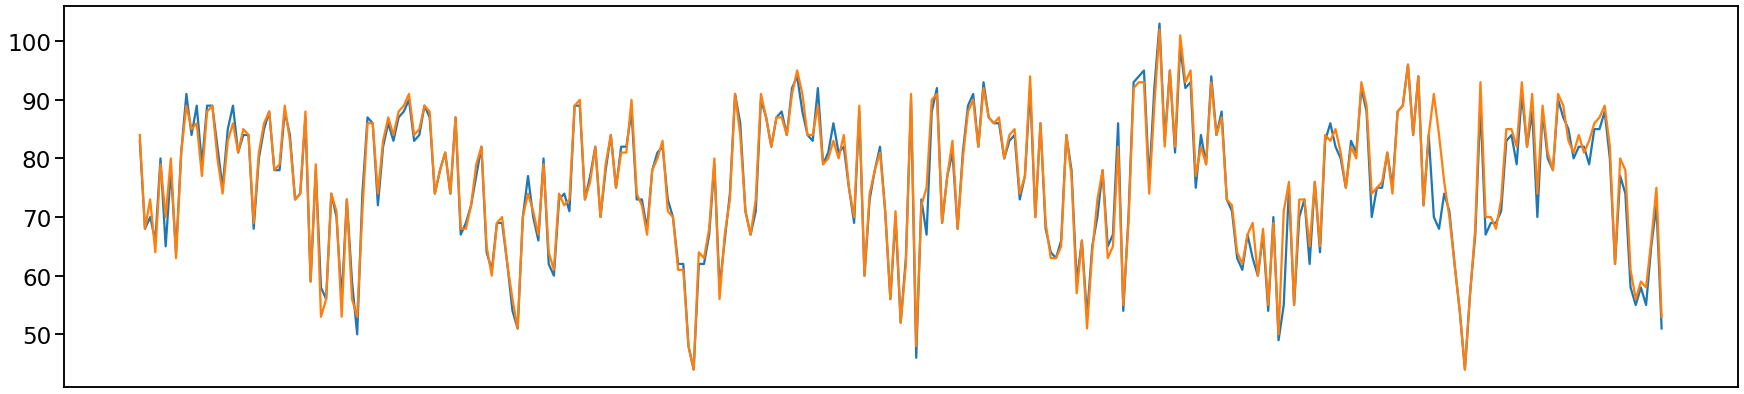

In [40]:
# plot of Tmax vs Date for the two stations
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,7))
ax.plot_date(weather_data_station1['Date'][::5], weather_data_station1['Tmax'][::5], xdate=True, fmt='-')
ax.plot_date(weather_data_station2['Date'][::5], weather_data_station2['Tmax'][::5], xdate=True, fmt='-')
plt.xticks(rotation='vertical')
ax.tick_params(labelbottom=False, bottom=False) 
plt.savefig('./figures/Tmax_station1and2.pdf', bbox_inches='tight')

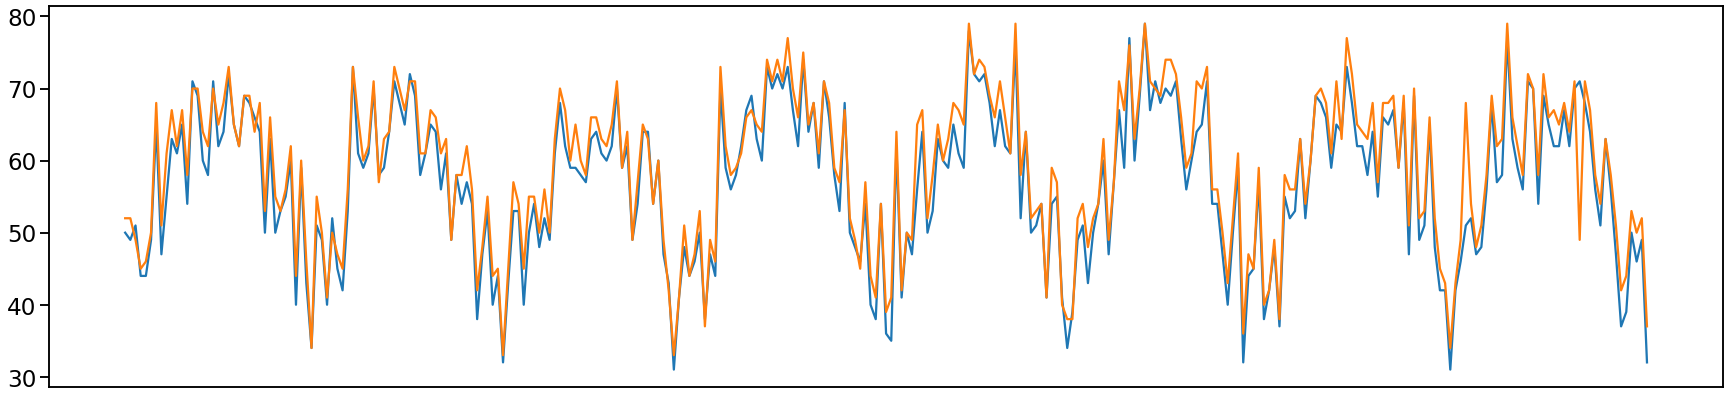

In [41]:
# plot of Tmin vs Date for the two stations
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,7))
ax.plot_date(weather_data_station1['Date'][::5], weather_data_station1['Tmin'][::5], xdate=True, fmt='-')
ax.plot_date(weather_data_station2['Date'][::5], weather_data_station2['Tmin'][::5], xdate=True, fmt='-')
plt.xticks(rotation='vertical')
ax.tick_params(labelbottom=False, bottom=False) 
plt.savefig('./figures/Tmin_station1and2.pdf', bbox_inches='tight')

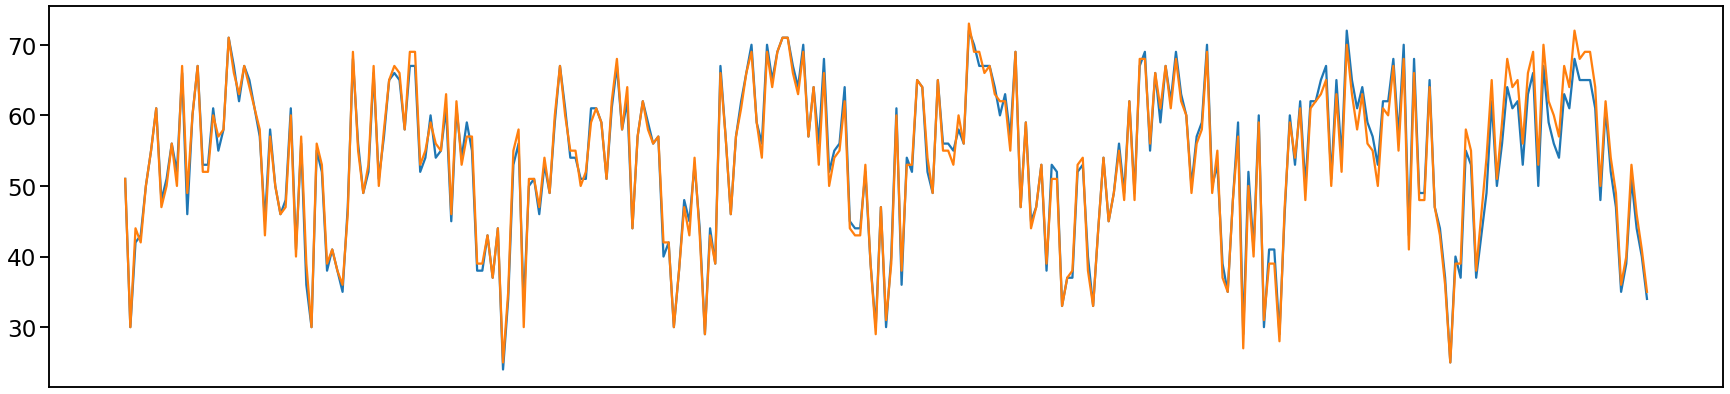

In [42]:
# plot of DewPoint vs Date for the two stations
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(30,7))
ax.plot_date(weather_data_station1['Date'][::5], weather_data_station1['DewPoint'][::5], xdate=True, fmt='-')
ax.plot_date(weather_data_station2['Date'][::5], weather_data_station2['DewPoint'][::5], xdate=True, fmt='-')
plt.xticks(rotation='vertical')
ax.tick_params(labelbottom=False, bottom=False) 
plt.savefig('./figures/DewPoint_station1and2.pdf', bbox_inches='tight')

Because of the high correlation between the the two stations and the fact station 2 has more missing data, we will go ahead and only use the data from station 1

In [43]:
weather_data = weather_data_station1.drop(columns='Station')
weather_data = weather_data.reset_index(drop=True)

In [44]:
weather_data.dtypes

Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
CodeSum         object
PrecipTotal     object
StnPressure     object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object

We are interested in transforming as many columns as possible into numeric columns to supply a predictive model. In some cases, the columns are just strings for no reasons. In other cases, there are string identifiers for missing data or null values. First we convert as many values to numerical as possible, and then we deal with the columns with missing values. For the precipitation, we are going to replace all the T values with the mean of 0 and the smallest detectable value (0.01) = 0.005.

We notice that 55% of all the data in this column is empty (' '), so we will first fill all the empty values with 'NA' (to mean that there was no special weather conditions).

## Convert as many columns into numerical types as possible

In [45]:
# Convert as many features to numerical types as possible
weather_data['Tavg'] = weather_data['Tavg'].astype(np.int64)
weather_data['Depart'] = weather_data['Depart'].astype(np.int64)
weather_data['AvgSpeed'] = weather_data['AvgSpeed'].astype(np.float)

# Replace trace with the average of 0 and the smallest detectable value, then convert to numeric.
weather_data['PrecipTotal'] = weather_data['PrecipTotal'].apply(lambda val: 0.005 if val == '  T' else val).astype(np.float)

# Replace ' ' in the CodeSum column with 'NA'.

weather_data['CodeSum'] = np.where(weather_data['CodeSum'] == ' ', 'NA', weather_data['CodeSum'])


## Backfilling missing values ('M') using the persistence model

Like I mentioned earlier, my goal is to convert as many of the columns as possible into numerical data types (where appropriate) so that I can evaluate to see if it is an important feature or not. There are some still some columns that are of type `object` because there are some missing values that are indicated by the value 'M'. We will remove these values, replace with an appropriate numerical value and then convert the entire column to a numerical type (where appropriate).

The strategy we take here is to fill each 'M' value with the same value as the previous day. This is sometimes called the persistence model; this is appropriate use for this model because weather changes only once every 3 days, so on any given day, it is more likely that the weather is the same as the previous day that is is different from the previous day. Later, we will examine more sophisticated ways to perform data imputation. This imputation process proceeds in two steps:

1. First replace 'M' values with `np.nan`
2. Backfill the `np.nan` values using values from the previous day (the persistence model)

We define a function `persistence_backfill` to do this for us.

In [46]:
# backfill WetBulb and StnPressure

for feature in ['WetBulb', 'StnPressure']:
    weather_data[feature] = persistence_backfill(weather_data, feature)

## Dealing with the `CodeSum` column

The `CodeSum` column is very rich with information because it encodes special event conditions such as tornadoes and thundershowers which can influence many things such as standing water, humidity, etc. For example, some thundershowers can lead to increased stangant water, but very frequent periods of thundershowers can lead to increased water run off and washing away of eggs, which can decrease the mosquito count. Instead of having strings, and to remove the dependence on the ordering of strings, we first split the string into a list, then order alphabetically (so that the days with the same weather conditions but with different ordering of CodeSum do not appear to be different). Finally, we create dummy columns for each significant weather condition. 

In [47]:
# Split and Sort the CodeSum column
weather_data['CodeSum'] = (weather_data['CodeSum'].apply(lambda s: sorted(s.split())))

In [48]:
# First find all the unique entries
codesum_entries = []
for l in weather_data['CodeSum']:
    codesum_entries.extend(l)
unique_codesum_entries = list(set(codesum_entries)) # There are only 15 unique CodeSum entires, but many more combinations of the various entries.

Next, we add dummy columns for each of the unique weather conditions

In [49]:
pos = 8
for entry in unique_codesum_entries:
    weather_data.insert(loc=pos, column=entry, value=np.zeros(weather_data.shape[0]))

In [50]:
for entry in unique_codesum_entries:
    entry_mask = (weather_data['CodeSum'].apply(lambda l: entry in l))*1
    weather_data[entry] = entry_mask

# Finally, we drop CodeSum because we now have dummy columns
weather_data.drop(columns='CodeSum')

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,RA,VCTS,TSRA,...,TS,HZ,FG+,NA,FU,PrecipTotal,StnPressure,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-01,83,50,67,14,51,56.0,0,0,0,...,0,0,0,1,0,0.000,29.10,1.7,27,9.2
1,2007-05-02,59,42,51,-3,42,47.0,0,0,0,...,0,0,0,0,0,0.000,29.38,13.0,4,13.4
2,2007-05-03,66,46,56,2,40,48.0,0,0,0,...,0,0,0,1,0,0.000,29.39,11.7,7,11.9
3,2007-05-04,66,49,58,4,41,50.0,1,0,0,...,0,0,0,0,0,0.005,29.31,10.4,8,10.8
4,2007-05-05,66,53,60,5,38,49.0,0,0,0,...,0,0,0,1,0,0.005,29.40,11.7,7,12.0
5,2007-05-06,68,49,59,4,30,46.0,0,0,0,...,0,0,0,1,0,0.000,29.57,14.4,11,15.0
6,2007-05-07,83,47,65,10,41,54.0,1,0,0,...,0,0,0,0,0,0.005,29.38,8.6,18,10.5
7,2007-05-08,82,54,68,12,58,62.0,0,0,0,...,0,0,0,0,0,0.000,29.29,2.7,11,5.8
8,2007-05-09,77,61,69,13,59,63.0,0,0,0,...,0,1,0,0,0,0.130,29.21,3.9,9,6.2
9,2007-05-10,84,56,70,14,52,60.0,0,0,0,...,0,0,0,0,0,0.000,29.20,0.7,17,4.1


Now we have cleaned, dataset of the weather with some dummy columns engineered in that would be helpful during our final feature engineering phase. 

## Feature Engineering the Weather Dataset

Our goal now is to add features form the weather dataset to the mosquito dataset. We do this feature engineering based on domain knowledge of the lifecycle of mosquitos. 

The lifecycle of the culex species of mosquitos is such that it takes about 7-10 days between the laying of the eggs and the emerging of the full size adults. Becuase this process requries water, high levels of precipitation in the 20 to 10 days before a particular sighting of a mosquito is likely to be correlated with higher mosquito poulation numbers. Too much rain might wash eggs away and decrease mosquito numbers.

Second, warmer temperatures during the incubation and molting periods for the eggs also leads to increased emergence of adult mosquitos, so we calculate the median max, min and average temperature over the preceeding ten days before a mosquito collection. The virus also spreads more easily at higher temperature. 

Thundershowers might lead to increased pooling of water but too many thundershowers might lead to the washing away of laid eggs. To capture this effect, we calculate the total number of heavy thundershower events, significant events arouns rain and drizzle, fog (to capture humidity), smoke and haze (smoke and haze might serve to kill mosquitos). 

Therefore, we engineer the following features:

1. `total_rainfall_10days`: The total amount of rainfall between 20 and 10 days before the observation date

2. `Tmax_median`, `Tmin_median` and `Tavg_median`: The median max, min and average temperatures in the 10 days preceeding the current observation date.

3. `FG_count`: Counts of FG, FG+ and BR events in the 10 days preceeding the observation date

4. `FU_count`: Total FU and HZ events in the ten days preceeding the observation

5. `TS_count`: Number of TS and TSRA events in the 20 to 10 days preceeding the observation 

6. `absolute_humidity` attempts to look at the effect of humidity without introducing correlations with temperature becuase it is calculated from various features and by definition looks at humidity independent of temperature.

In [51]:
# Build the features and add to the mosquito_data_lr_sampled dataframe
tqdm.pandas()

# Fog might increase humidity which might increase number of eggs so we use between 20 and 10 days
mosquito_data_lr_sampled['FG_count'] = mosquito_data_lr_sampled.progress_apply(lambda row: significant_event_count(date=row['Date'], day_first=20, day_last=10, feature=['FG', 'FG+']), axis=1)

# Smoke and haze might serve to kill mosquitos so we use the last ten days (count of adult is influenced)
mosquito_data_lr_sampled['FU_count'] = mosquito_data_lr_sampled.progress_apply(lambda row: significant_event_count(date=row['Date'], day_first=10, day_last=0, feature=['FU', 'HZ']), axis=1)

# Thunershowers might change the number of eggs (either increase or wash them away if too many) so we use between 0 and 10 days
mosquito_data_lr_sampled['TS_count'] = mosquito_data_lr_sampled.progress_apply(lambda row: significant_event_count(date=row['Date'], day_first=10, day_last=0, feature=['TS', 'TSRA']), axis=1)

#Temperature affect both the development of eggs as well as spread of the virus so we use the preceeding 10 days. We only include Tavg, not Tmax and Tmin to avoid correlated variables
mosquito_data_lr_sampled['Tavg_median'] = mosquito_data_lr_sampled.progress_apply(lambda row: temp_median(row['Date'], 'Tavg'), axis=1)

# Instead of using the dewpoint as the measure of humidity, we are going to use the absolute humidity. This is because dew point temperature are strongly correlated with the dry bulb temperature
# and including both leads to strongly correlated variables
mosquito_data_lr_sampled['DewPoint_median'] = mosquito_data_lr_sampled.progress_apply(lambda row: temp_median(row['Date'], 'DewPoint'), axis=1)
mosquito_data_lr_sampled['WetBulb_median'] = mosquito_data_lr_sampled.progress_apply(lambda row: temp_median(row['Date'], 'WetBulb'), axis=1)
mosquito_data_lr_sampled['absolute_humidity'] = mosquito_data_lr_sampled.progress_apply(lambda row: absolute_humidity(row['Date']), axis=1)


# Total rainfall can affect the amount of stagnant water and hence the density of the eggs so we will use between 20 and 10 days
mosquito_data_lr_sampled['total_rainfall_10days'] = mosquito_data_lr_sampled.progress_apply(lambda row: total_rainfall(row['Date']), axis=1)


100%|██████████| 1102/1102 [00:01<00:00, 798.92it/s]


### Correlations between the various features and the presence of WNV

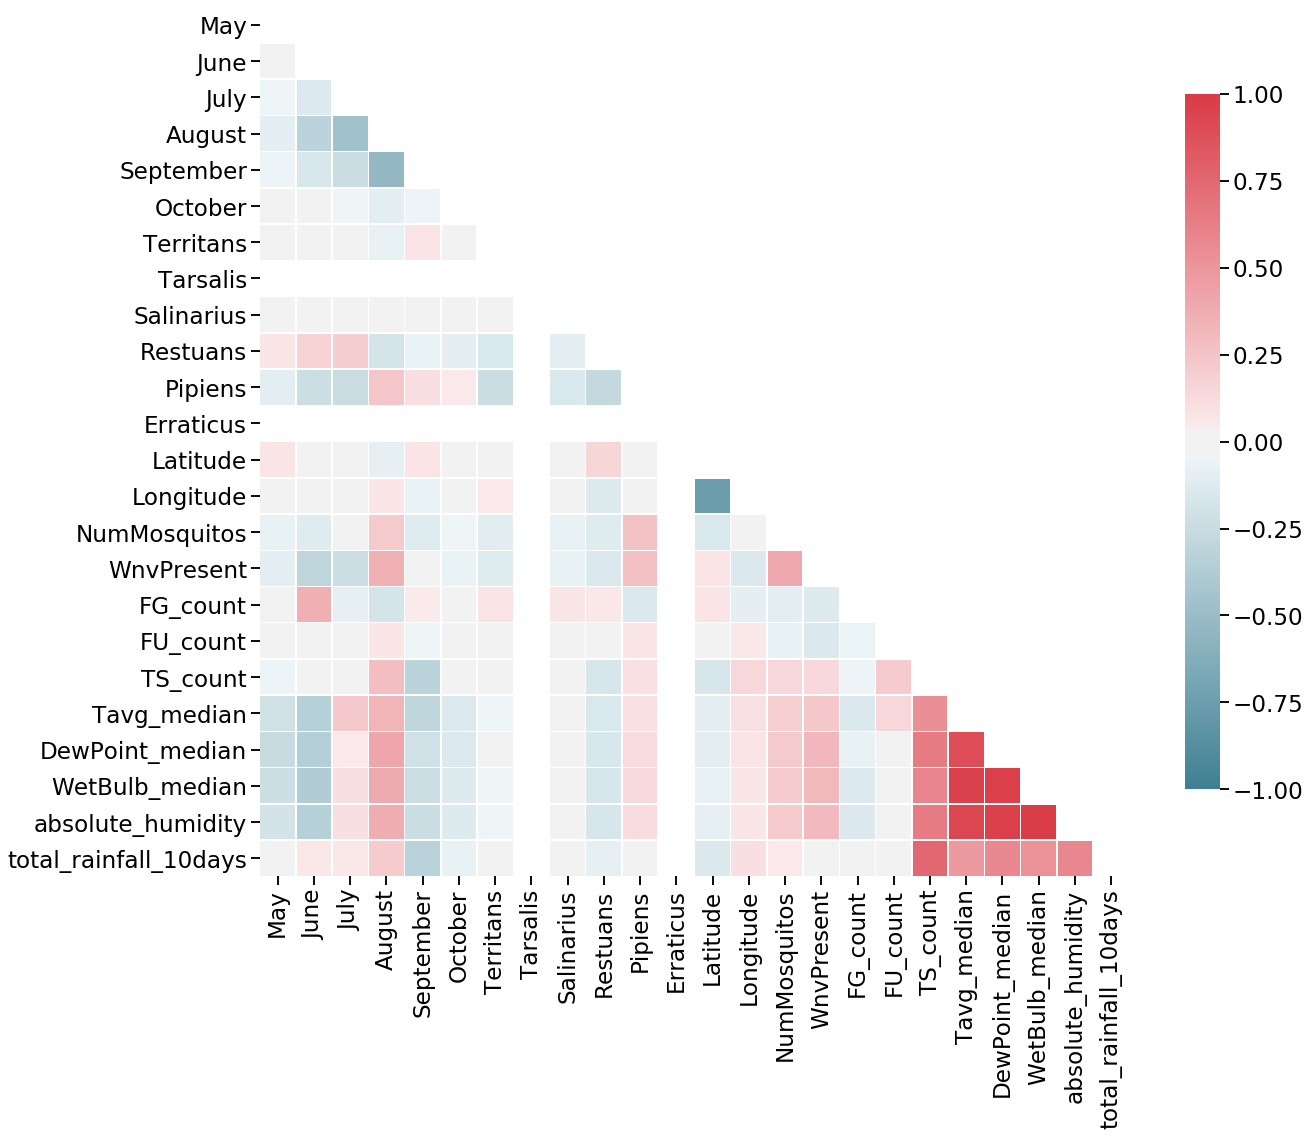

In [52]:
corr_sampled = (mosquito_data_lr_sampled[mosquito_data_lr_sampled.columns[1:]]).corr()
mask = np.triu(np.ones_like(corr_sampled, dtype=np.bool))
f_corr, ax_corr = plt.subplots(figsize=(20, 16))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax_corr = sns.heatmap(corr_sampled, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
f_corr.savefig('all_features_corr.pdf', bbox_inches='tight')

In [53]:
print(mosquito_data_lr_sampled.columns.to_list())

['Date', 'May', 'June', 'July', 'August', 'September', 'October', 'Territans', 'Tarsalis', 'Salinarius', 'Restuans', 'Pipiens', 'Erraticus', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'FG_count', 'FU_count', 'TS_count', 'Tavg_median', 'DewPoint_median', 'WetBulb_median', 'absolute_humidity', 'total_rainfall_10days']


In [54]:
# reorder columns and drop TARSALIS, ERRATICUS because they occur very sparsely in the model. We also drop WetBulb_median, and absolute_humidity because it is so strongly correlated with Tavg_median. In essence, it seems that we do not have to account separately for humidity.

mosquito_data_lr_sampled = mosquito_data_lr_sampled[['Date', 'May', 'June', 'July', 'August', 'September', 'October', 'Territans', 'Salinarius', 'Restuans', 'Pipiens', 'Latitude', 'Longitude', 'NumMosquitos', 'FG_count', 'FU_count', 'TS_count', 'Tavg_median', 'DewPoint_median', 'total_rainfall_10days', 'absolute_humidity', 'WnvPresent']]

## Performing a logistic regression fit to the augmented mosquito_data_lr_sampled dataset

Now we try and fit a logistic regression model as before (without any regularization for now) and see if we perform any better in terms of accuracy, roc-auc and f1 score. Then we will do lasso regression and find the regularization parameter using K-fold cross validation. Finally, after seeing which parameters are driven to 0, we will interpret the parameters in terms of how important a driver they are for the presence of west nile virus.

In [55]:
cols = mosquito_data_lr_sampled.columns
X = mosquito_data_lr_sampled[cols[1:-1]]
y = mosquito_data_lr_sampled[cols[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

scaler_train = StandardScaler()
X_train = scaler_train.fit_transform(X=X_train, y=y_train)

scaler_test = StandardScaler()
X_test = scaler_test.fit_transform(X=X_test, y=y_test)

clf = LogisticRegression(penalty='l1', C=.13, solver='liblinear')
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(f'The test accuracy is {accuracy_score(y_predict, y_test)}')

The test accuracy is 0.8099547511312217


### Plot the ROC and find the accuracy and F1 score

ROC AUC=0.8636661747827512
The F1 score for the model is 0.8189655172413792


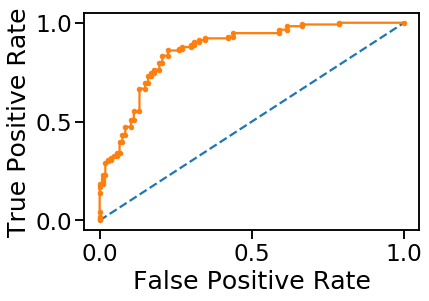

In [56]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
print(f'ROC AUC={lr_auc}')
print(f'The F1 score for the model is {f1_score(y_predict, y_test)}')

### Find feature importances

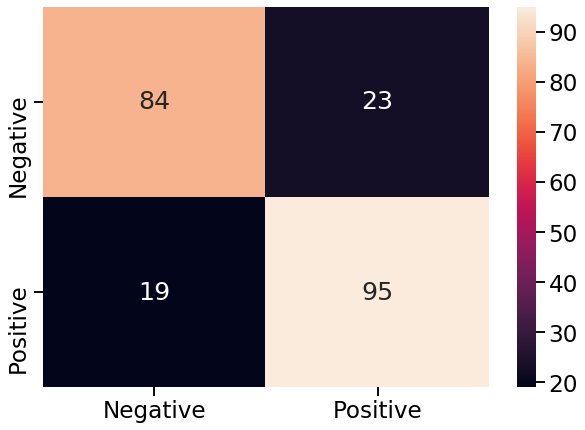

In [57]:
cm = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index = ['Negative', 'Positive'],
                  columns = ['Negative', 'Positive'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

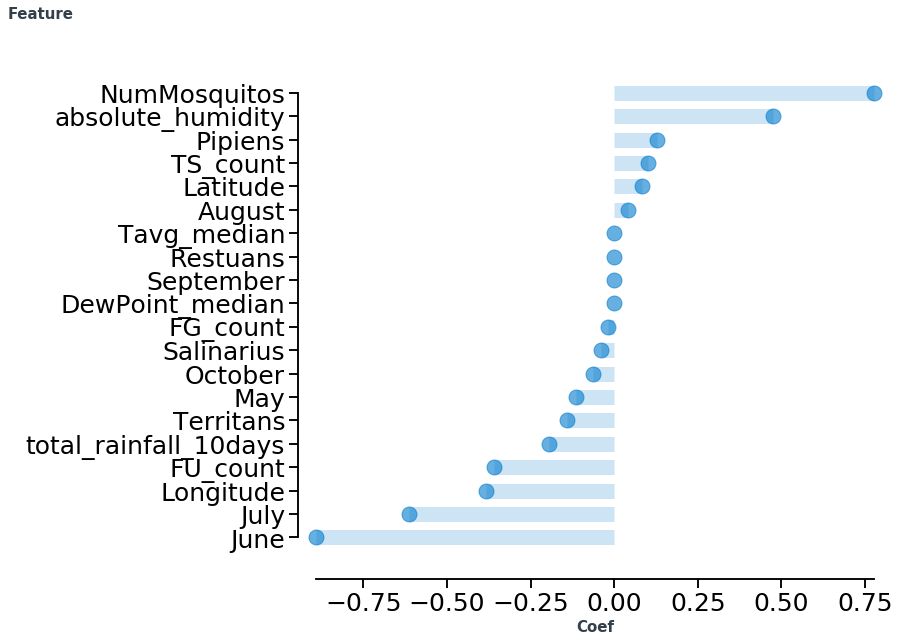

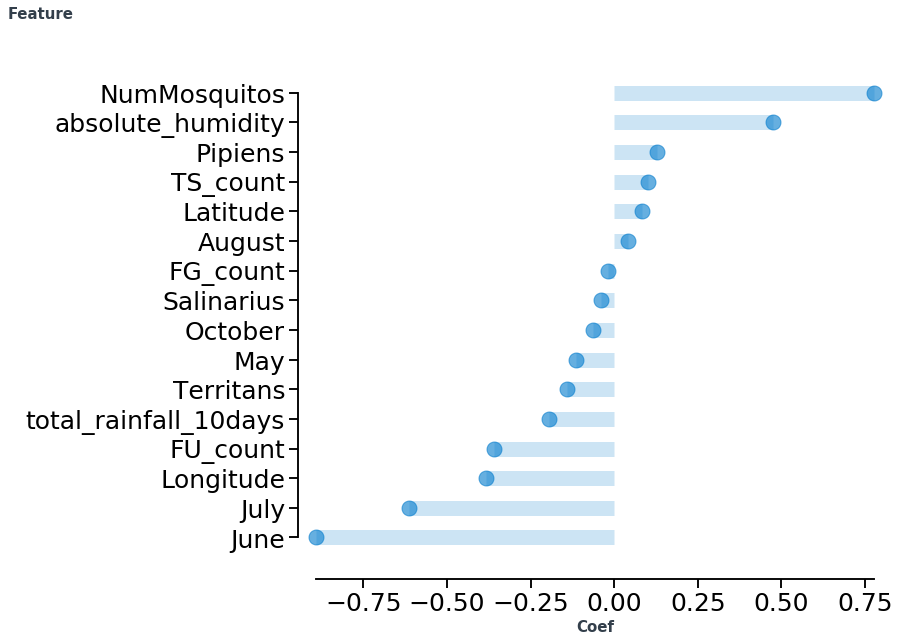

In [58]:
# Plot all features regardless of coefficient
lr_coefs = clf.coef_[0]
feature_cols = cols[1:-1]
lr_coef_df = pd.DataFrame(columns=['Feature', 'Coef'])
lr_coef_df['Feature'], lr_coef_df['Coef'] = feature_cols, lr_coefs
lr_coef_df = lr_coef_df.sort_values(by='Coef', ascending=False)

# fig_lr_coef, ax_lr_coef = plt.subplots(nrows=1, ncols=1, figsize=(19,7))
# ax_lr_coef.set_xticklabels(labels=lr_coef_df['Feature'], rotation=90)
# ax_lr_coef = sns.barplot(x='Feature', y='Coef', color='cornflowerblue', data=lr_coef_df)
pretty_barplot(lr_coef_df['Feature'], lr_coef_df['Coef'], 'Coef', 'Feature', 'with_weather_model_feature_importance_all')

# Plot only features with non-zero coefficients
lr_coef_nonzero_df = lr_coef_df[lr_coef_df['Coef'] != 0]

pretty_barplot(lr_coef_nonzero_df['Feature'], lr_coef_nonzero_df['Coef'], 'Coef', 'Feature', 'with_weather_model_feature_importance_nonzero')

### Plot the confusion matrix

## Regularization

This model with the augmented weather data does not perform that much better than the model without the weather data. This could be because we have too many parameters and we are overfitting the dataset. To understand this better and to prevent the possibility of overfitting, we perform L1 regularization (Lasso regression) and find the optimal parameter using K-fold cross validation.

It turns out that the optial parameter for regularization is C = .09, which is what we use in the logistic regression

100%|██████████| 100/100 [00:06<00:00,  9.43it/s]
The optimal regularization parameter is 0.13


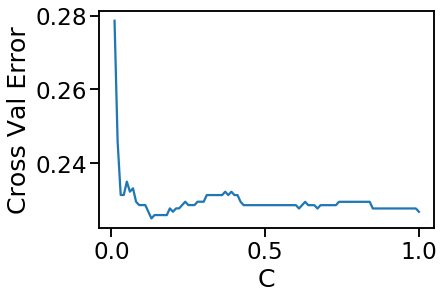

In [59]:
cv_scores = []
C = np.linspace(.01, 1, int((1 - .01)/.01)+1)
cols = mosquito_data_lr_sampled.columns
X = mosquito_data_lr_sampled[cols[1:-1]]
y = mosquito_data_lr_sampled[cols[-1]]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=50)

scaler_cross_val = StandardScaler()
X = scaler_train.fit_transform(X=X, y=y)

for c in tqdm(C):
    clf = LogisticRegression(penalty='l1', C=c, solver='liblinear')
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

#graphical view
#misclassification error
error = [1-x for x in cv_scores]
#optimal C
optimal_C_idx = error.index(min(error))
optimal_C = C[optimal_C_idx]
print(f'The optimal regularization parameter is {optimal_C}')
# plot misclassification error vs C
plt.plot(C, error)
plt.xlabel('C')
plt.ylabel('Cross Val Error')
plt.show()

## Recursive Feature Elimination to find most important features

In [60]:
clf_rfecv = LogisticRegression(penalty='l1', C=.13, solver='liblinear')
rfecv = RFECV(estimator=clf_rfecv, step=1, cv=5, scoring='accuracy')
rfecv.fit(X_train, y_train)

RFECV(cv=5,
      estimator=LogisticRegression(C=0.13, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='warn', n_jobs=None,
                                   penalty='l1', random_state=None,
                                   solver='liblinear', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

In [61]:
print('Optimal number of features: {}'.format(rfecv.n_features_))
coefs = list(rfecv.estimator_.coef_.reshape(-1))

Optimal number of features: 7


In [62]:
feature_cols = cols[1:-1]
important_features = []
unimportant_col_idx = np.where(rfecv.support_==False)[0]
for i in range(len(feature_cols)):
    if i not in unimportant_col_idx:
        important_features.append(feature_cols[i])
print(important_features)

['June', 'July', 'Longitude', 'NumMosquitos', 'FU_count', 'total_rainfall_10days', 'absolute_humidity']


## Testing Model with Trimmed Feature Set

In [63]:
trimmed_mosquito_data_lr_sampled = mosquito_data_lr_sampled[important_features + ['WnvPresent']]

### Correlations between the downsampled dataset

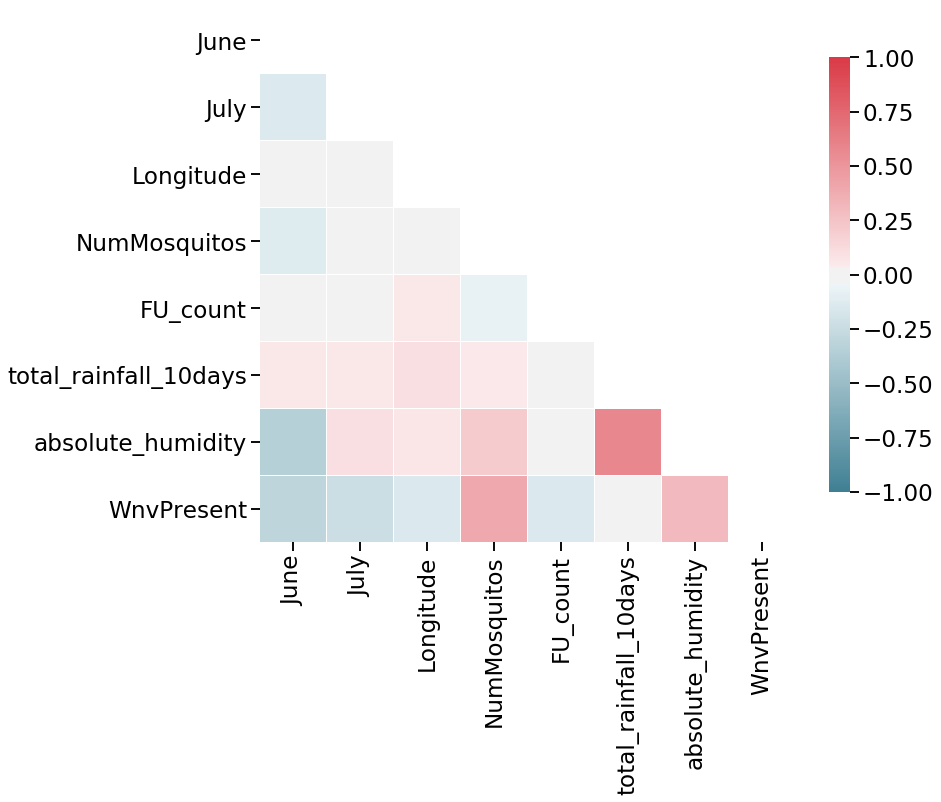

In [64]:
corr_trimmed_sampled = (trimmed_mosquito_data_lr_sampled[trimmed_mosquito_data_lr_sampled.columns]).corr()
mask = np.triu(np.ones_like(corr_trimmed_sampled, dtype=np.bool))
f_corr, ax_corr = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax_corr = sns.heatmap(corr_trimmed_sampled, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})
f_corr.savefig('trimmed_features_corr.pdf', bbox_inches='tight')

### Logistic Regression on trimmed feature set

In [65]:
cols = trimmed_mosquito_data_lr_sampled.columns
X = trimmed_mosquito_data_lr_sampled[cols[1:-1]]
y = trimmed_mosquito_data_lr_sampled[cols[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

scaler_train = StandardScaler()
X_train = scaler_train.fit_transform(X=X_train, y=y_train)

scaler_test = StandardScaler()
X_test = scaler_test.fit_transform(X=X_test, y=y_test)

clf = LogisticRegression(penalty='l1', C=.04, solver='liblinear')
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
print(f'The test accuracy is {accuracy_score(y_predict, y_test)}')

The test accuracy is 0.8054298642533937


### Plot ROC AUC curve

ROC AUC=0.8392359403180849
The F1 score for the model is 0.8088888888888889


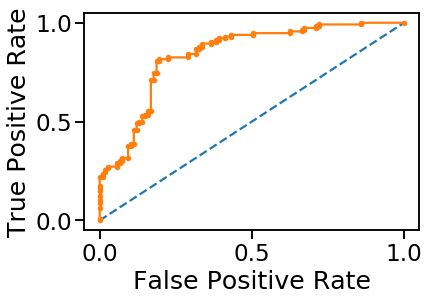

In [66]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = clf.predict_proba(X_test)
lr_probs = lr_probs[:, 1]

ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
print(f'ROC AUC={lr_auc}')
print(f'The F1 score for the model is {f1_score(y_predict, y_test)}')

### Plot Confusion Matrix

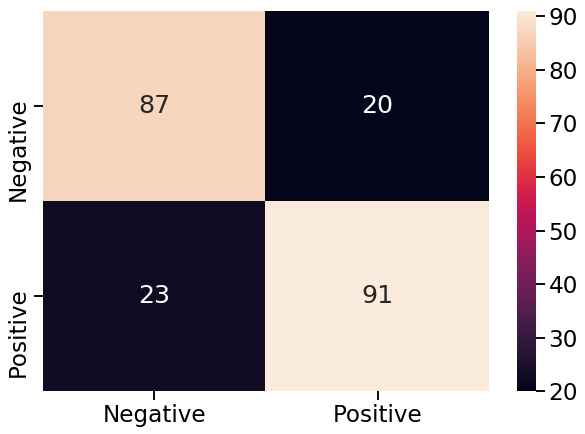

In [67]:
cm = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index = ['Negative', 'Positive'],
                  columns = ['Negative', 'Positive'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

### Plot Feature Importances

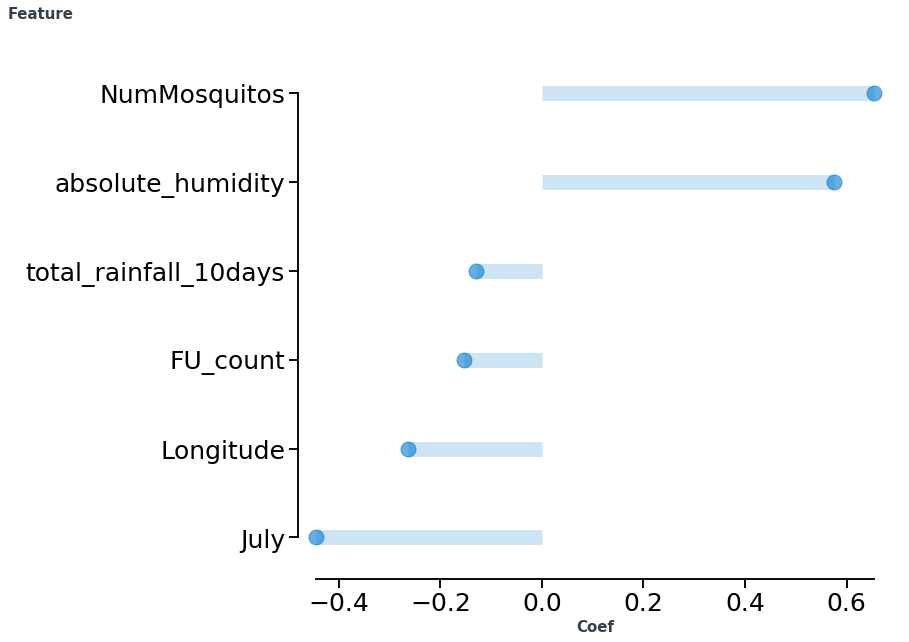

In [68]:
lr_coefs = clf.coef_[0]
feature_cols = cols[1:-1]
lr_coef_df = pd.DataFrame(columns=['Feature', 'Coef'])
lr_coef_df['Feature'], lr_coef_df['Coef'] = feature_cols, lr_coefs
lr_coef_df = lr_coef_df.sort_values(by='Coef', ascending=False)

pretty_barplot(lr_coef_df['Feature'], lr_coef_df['Coef'], 'Coef', 'Feature', 'with_weather_model_feature_importance_simplified')